## House Energy Consumption

In [72]:
import numpy as np
import pandas as pd
import test
import datetime
from datetimerange import DateTimeRange
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', None)

from IPython.display import clear_output
import timeit
import seaborn as sns 

import random


In [2]:
def _color_red_or_green(val):
    if val =='empty':
        color = 'green'  
    elif isinstance(val, int):
        color = 'black'
    else:
        color = 'red'
    return 'color: %s' % color

In [3]:
day_of_the_week_dict = {
    0:'Mon',
    1:'Tue',
    2:'Wed',
    3:'Thu',
    4:'Fri',
    5:'Sat',
    6:'Sun',
}

In [26]:
class Appliance:

    def __init__(self,
                 name=None,
                 start_time=0, 
                 start_power = 0,
                ):
        
        self.name = name
        self.start_time = start_time
        self.start_power = start_power
        
        self.vector = [(start_time, start_power)]

    def get_info(self):
        return self.vector

    def add_point(self, new_point_list):
        if type(new_point_list) is list:
            for new_point in new_point_list:
                self.vector.append(new_point)
        else:
            return 'error: please enter a list'
    
    def clear_all_points(self):
        self.vector = [(start_time, start_power)]
        
    def delete_last_point(self):
        self.vector = self.vector[:-1]
    
    def __str__(self):
        return self.name

In [43]:
class Time_list:
    
    def __init__(self, 
                 start_time=datetime.datetime(2023, 1, 1, 0), 
                 end_time=datetime.datetime(2023, 1, 1, 23), 
                 increment=1):
        
        self.start_time = start_time
        self.end_time = end_time
        self.time_range = DateTimeRange(self.start_time, self.end_time)
        self.time_list =[]
        self.increment = increment
        for value in self.time_range.range(datetime.timedelta(minutes = self.increment)):
            self.time_list.append(value)

        self.df_base = pd.DataFrame(
            self.time_list,
            columns = ['time']
        )
            
    def add_item(self, 
                 item, 
                 start_time_item):

        end_time_item = start_time_item + datetime.timedelta(minutes=item.vector[-1][0])
        time_range_item = DateTimeRange(start_time_item, end_time_item)

        time_list_item =[]

        for value in time_range_item.range(datetime.timedelta(minutes = self.increment)):
            time_list_item.append(value)

        vector_datetime = []
        
        for point in item.vector:
            point_time = start_time_item + datetime.timedelta(minutes=int(point[0]))
            vector_datetime.append((point_time, point[1]))
        
        vector_datetime_short = [(k, v) for k, v in dict(vector_datetime).items()]
#         print(vector_datetime_short)
        
        k = 0
        current_power = vector_datetime_short[0][0]
        result_list = []

        for current_time in time_list_item:

            if current_time == vector_datetime_short[k][0]:
                current_power = vector_datetime_short[k][1]

                result_list.append((current_time, current_power))
                k +=1

            else:
                result_list.append((current_time, current_power))
      
        df_new = pd.DataFrame(
            result_list,
            columns = ['time','{}'.format(item.name)]
        )
        
#         display(df_new)
        
        self.df_base = pd.merge(self.df_base, df_new, how='left', on='time') 
        self.df_base.fillna(0,inplace=True)
        

In [44]:
directory = './consumption_input_file.xlsx'
sheet_name_list = list(pd.read_excel(directory, None).keys())
df_summary = pd.read_excel(directory, sheet_name = sheet_name_list[0], index_col='appliance')


In [64]:
import random
random.seed(9)

start_time = datetime.datetime(2023, 1, 2, 5)
end_time = datetime.datetime(2023, 1, 3, 5)

test_time_list = Time_list(start_time=start_time,
                           end_time=end_time
                          )

df_master = pd.DataFrame(pd.Series(test_time_list.time_list), columns = ['time'])

for sheet_name in sheet_name_list[1:]:

    df_temp = pd.read_excel(directory, sheet_name = sheet_name)[['time','power']].dropna()
    
    ##############
    # change input data points if recurring == 1
    ## objective is to change temp_points

    if df_summary.loc['{}'.format(sheet_name), '24_hour_recurring'] == 1:    
        concat_list = list(df_temp.itertuples(index=False, name=None))
        max_value = max([a for a, b in concat_list])

        ### loop for 24 hours
        while max_value <= 60*23:
            time_list = [a+max_value for a, b in concat_list]
            value_list = [b for a, b in concat_list]
            new_list = list(zip(time_list, value_list))
            concat_list = concat_list + new_list
            
            max_value = max([a for a, b in concat_list])  
    
            temp_points = concat_list
    else:  

        temp_points =  list(df_temp.itertuples(index=False, name=None))
    
    ##############
    # create Appliance
    
    temp_input = Appliance(name=sheet_name)
    temp_input.add_point(temp_points)
    
    ##############
    # create hour_list
    ## note: 24 hour itteration is already carried out above
    ### .iloc[:,9:] is to remove control columns and extract time columns
    
    hour_flat_list = list(df_summary.iloc[:,9:].loc['{}'.format(sheet_name)].dropna())
    hour_tutple_pair_list = []

    ##############
    
    ##############
    # Convert time list to pair of tuples
    for i in range(0, len(hour_flat_list), 2):
        hour_tutple_pair_list.append((hour_flat_list[i], hour_flat_list[i+1]))
    ##############
    
    ##############
    # Carry out operation if the time of the day is right
    day_of_week = day_of_the_week_dict[datetime.datetime(2023, 1, 2).weekday()]
    probability = df_summary.loc[:,day_of_week][sheet_name]
    
    random_number = random.random()
    if random_number <= probability:
        print(sheet_name, random_number)
        
        ##############

        for temp_time in hour_tutple_pair_list:
            base_time = datetime.datetime(2023, 1, 2,int(temp_time[0]), int(temp_time[1]))
            random_starting_time = df_summary.loc['{}'.format(sheet_name), 'range']
            starting_time = base_time + datetime.timedelta(minutes=int(np.random.normal(0, random_starting_time, 1)))
            test_time_list.add_item(temp_input, starting_time)

        df_temp_consolidate_1 = test_time_list.df_base.filter(regex='{}'.format(sheet_name))
        df_temp_consolidate_2 = pd.concat([pd.Series(test_time_list.time_list), df_temp_consolidate_1.T.sum()], axis=1)    
        df_temp_consolidate_2.columns = ['time', '{}'.format(sheet_name)]
        df_master = pd.merge(df_master, df_temp_consolidate_2, how='left', on = 'time')


refrigerator 0.46300735781502145
dish_washer 0.13853941251445523
iron 0.006435054081123326
hair_dryer 0.5027820800522084
kettle 0.8982979700319381
cooker_fan 0.08081464718300102
toaster 0.5542704681782861


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: Passing 'suffixes' which cause duplicate columns {'kettle_x'} in the result is deprecated and will raise a MergeError in a future version.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TV_x'} in the result is deprecated and will raise a MergeError in a future version.


TV 0.6166500426836184
desktop 0.04089576548481155
light 0.3790196043954357


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: Passing 'suffixes' which cause duplicate columns {'desktop_x'} in the result is deprecated and will raise a MergeError in a future version.


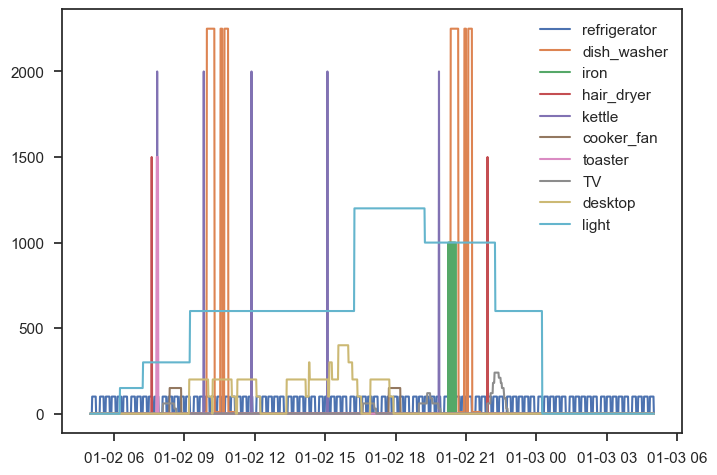

In [65]:
x = df_master.loc[:,'time']
for sheet_name in df_master.columns[1:]:
    y = df_master.loc[:,sheet_name]
    
    plt.plot(x, y, label = sheet_name)
plt.legend()

In [66]:
df_master_2 = df_master
df_master_2.index = df_master_2.iloc[:,0]
df_master_2 = df_master_2.iloc[:,1:]

Text(0.5, 0, 'Hour')

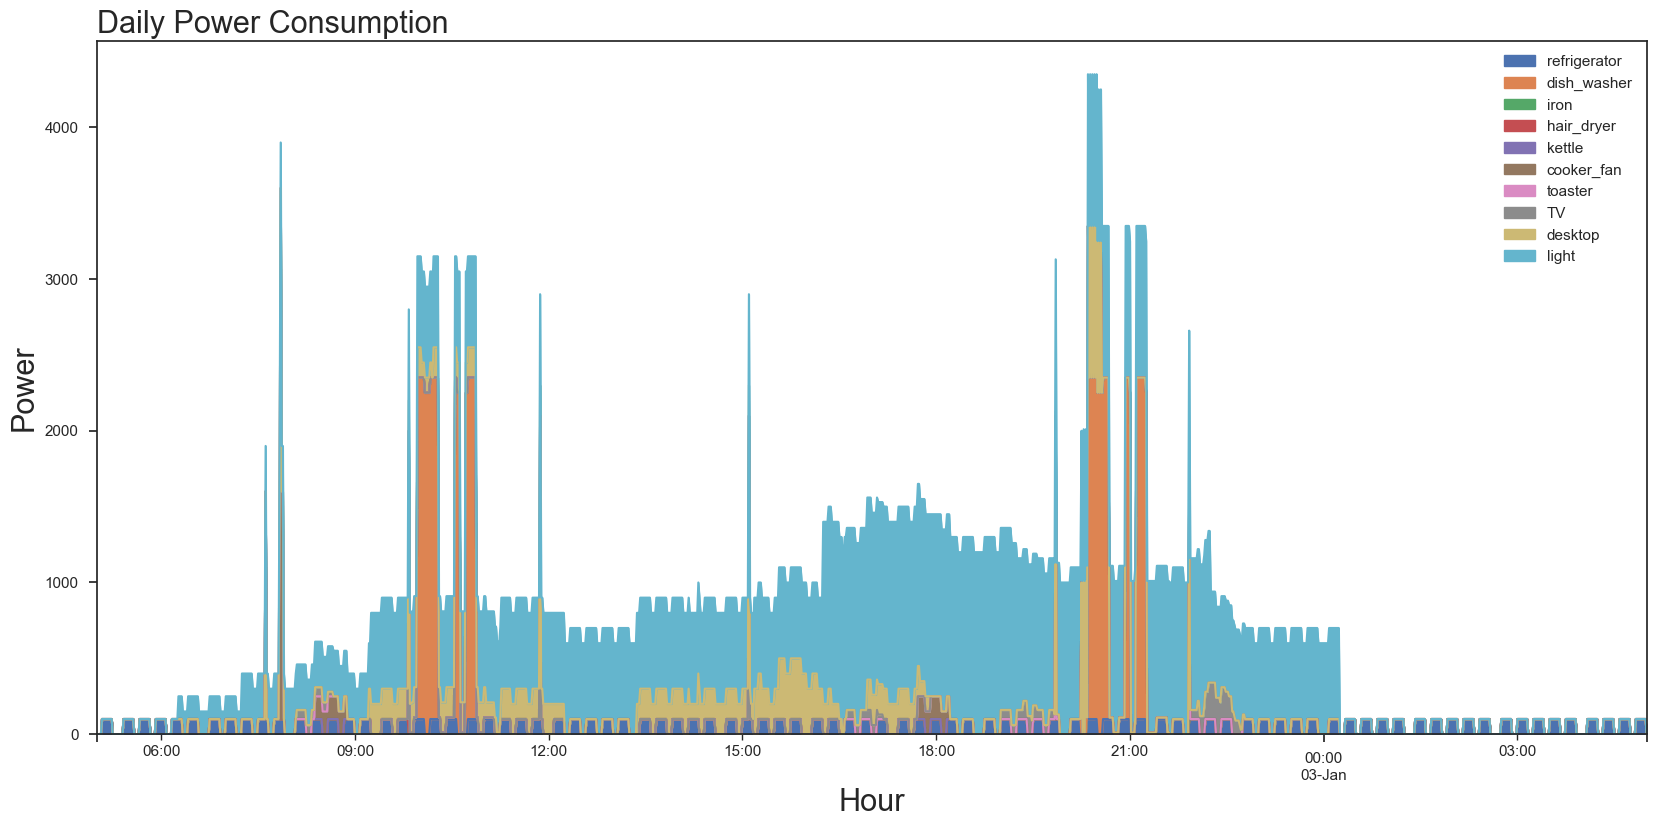

In [67]:
df_master_2 = df_master
df_master_2.index = df_master_2.iloc[:,0]
df_master_2 = df_master_2.iloc[:,1:]

# colors = sns.color_palette("RdBu", 7)

plt.style.use('seaborn')
sns.set_style("white")
sns.set_theme(style = "ticks")

df_master_2.plot.area(figsize = (20,9))
plt.title("Daily Power Consumption", fontsize = 22, loc = 'left')
plt.ylabel("Power", fontsize = 22)
plt.xlabel("Hour", fontsize = 22)


In [49]:
df_master_2

,refrigerator,dish_washer,iron,hair_dryer,kettle,cooker_fan,toaster,TV,desktop,light
time,,,,,,,,,,
2023-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-01-02 23:56:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02 23:57:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02 23:58:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='time'>

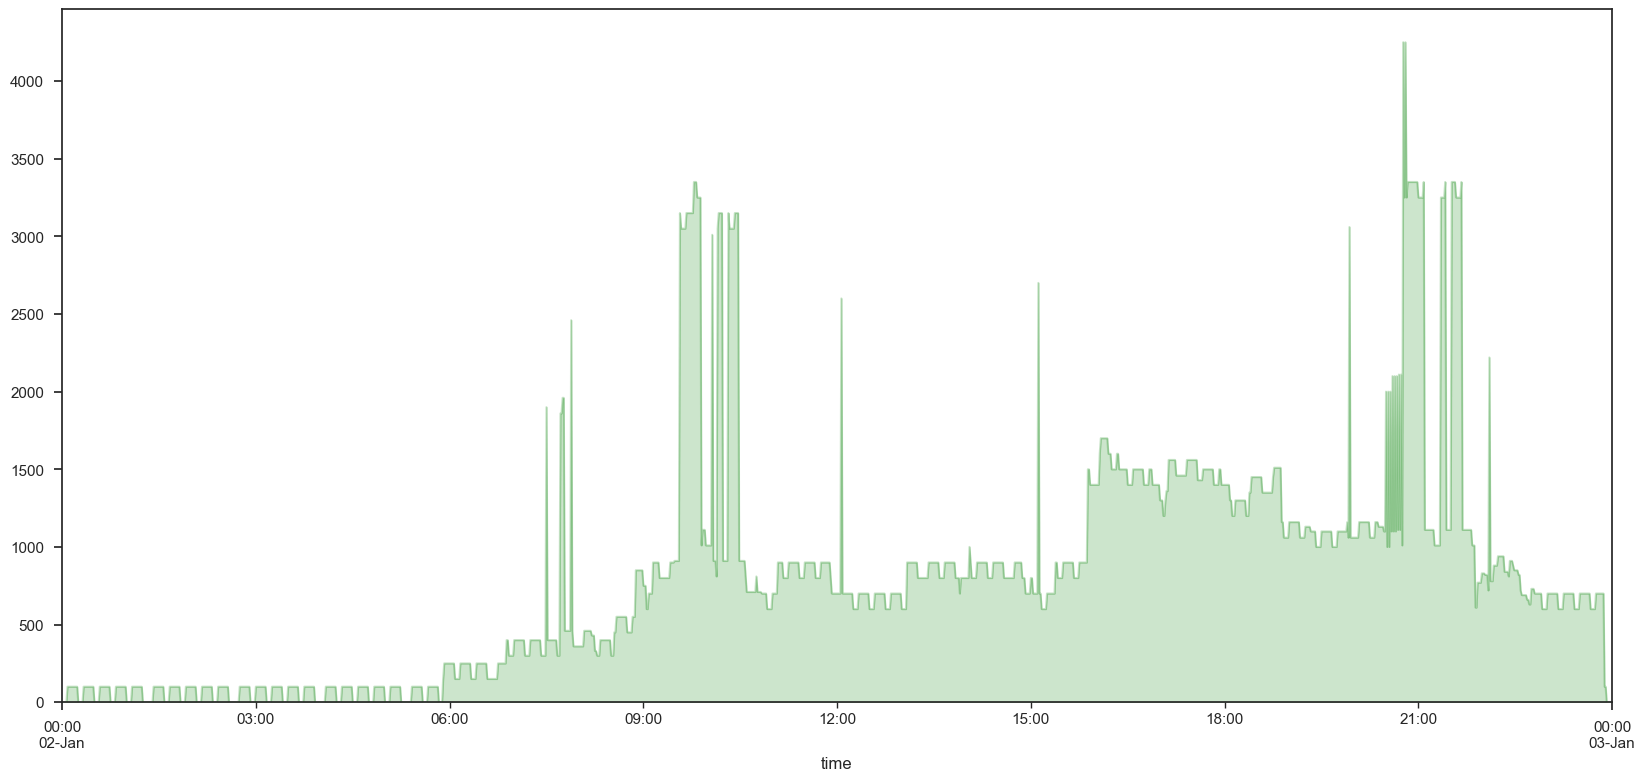

In [50]:
df_master_2.T.sum().plot.area(figsize = (20,9), color = 'green', 
                              alpha = 0.2)

# With EVSE

Text(0.5, 0, 'Hour')

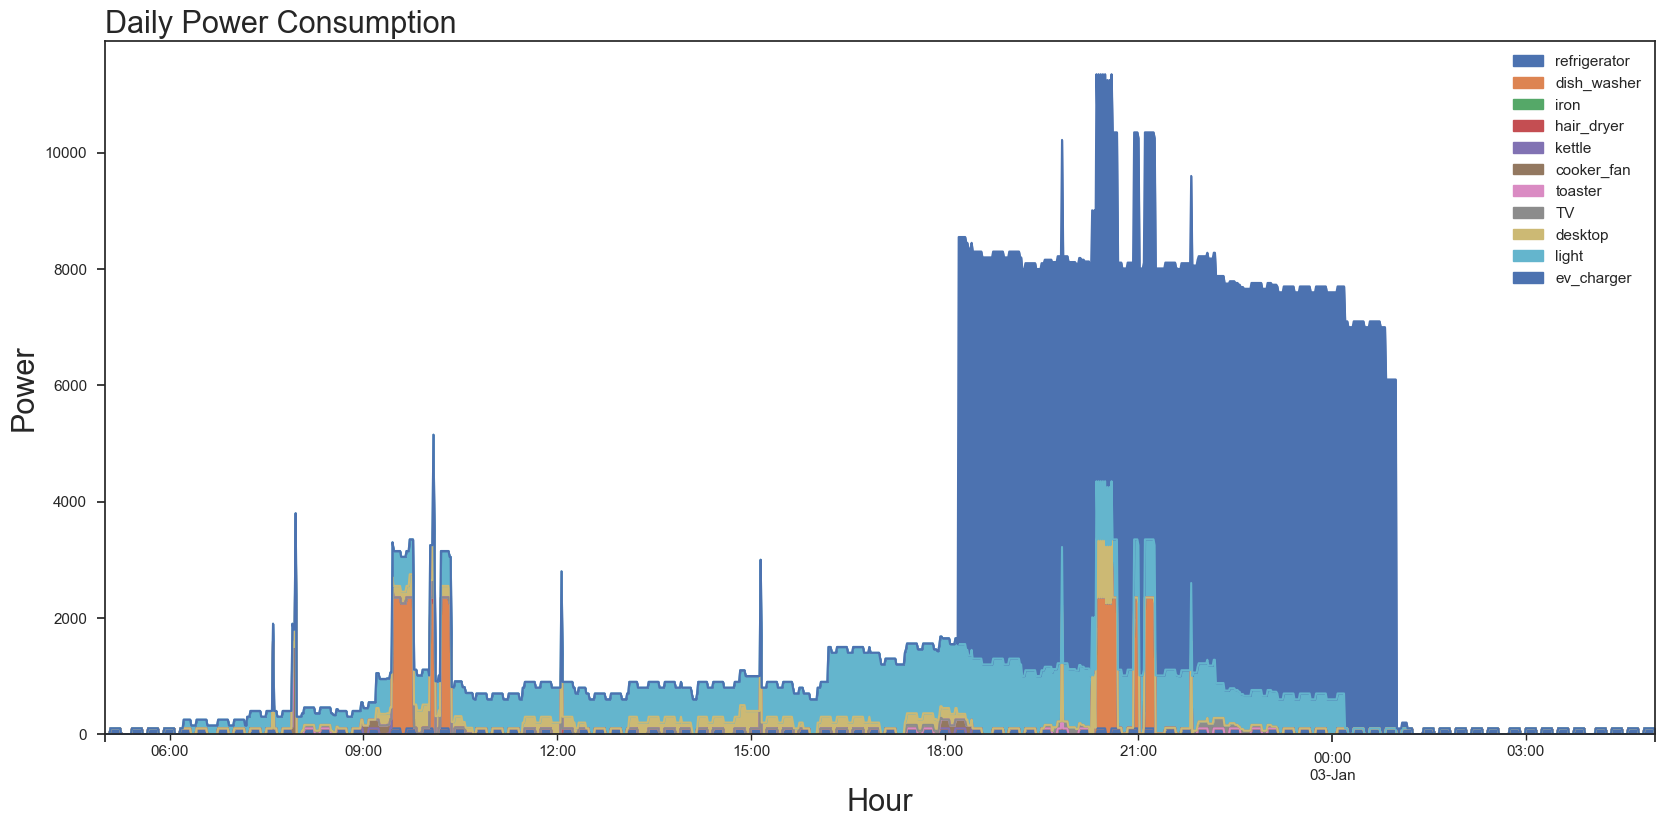

In [75]:
%%capture --no-display

random.seed(9)


directory = './consumption_input_file.xlsx'
sheet_name_list = list(pd.read_excel(directory, None).keys())
df_summary = pd.read_excel(directory, sheet_name = sheet_name_list[0], index_col='appliance')

start_time = datetime.datetime(2023, 1, 2, 5)
end_time = datetime.datetime(2023, 1, 3, 5)

test_time_list = Time_list(start_time=start_time,
                           end_time=end_time
                          )

df_master = pd.DataFrame(pd.Series(test_time_list.time_list), columns = ['time'])

for sheet_name in sheet_name_list[1:]:

    df_temp = pd.read_excel(directory, sheet_name = sheet_name)[['time','power']].dropna()
    
    ##############
    # change input data points if recurring == 1
    ## objective is to change temp_points

    if df_summary.loc['{}'.format(sheet_name), '24_hour_recurring'] == 1:    
        concat_list = list(df_temp.itertuples(index=False, name=None))
        max_value = max([a for a, b in concat_list])

        ### loop for 24 hours
        while max_value <= 60*23:
            time_list = [a+max_value for a, b in concat_list]
            value_list = [b for a, b in concat_list]
            new_list = list(zip(time_list, value_list))
            concat_list = concat_list + new_list
            
            max_value = max([a for a, b in concat_list])  
    
            temp_points = concat_list
    else:  

        temp_points =  list(df_temp.itertuples(index=False, name=None))
    
    ##############
    # create Appliance
    
    temp_input = Appliance(name=sheet_name)
    temp_input.add_point(temp_points)
    
    ##############
    # create hour_list
    ## note: 24 hour itteration is already carried out above
    ### .iloc[:,9:] is to remove control columns and extract time columns
    
    hour_flat_list = list(df_summary.iloc[:,9:].loc['{}'.format(sheet_name)].dropna())
    hour_tutple_pair_list = []

    ##############
    
    ##############
    # Convert time list to pair of tuples
    for i in range(0, len(hour_flat_list), 2):
        hour_tutple_pair_list.append((hour_flat_list[i], hour_flat_list[i+1]))
    ##############
    
    ##############
    # Carry out operation if the time of the day is right
    day_of_week = day_of_the_week_dict[datetime.datetime(2023, 1, 2).weekday()]
    probability = df_summary.loc[:,day_of_week][sheet_name]
    
    random_number = random.random()
    if random_number <= probability:
        print(sheet_name, random_number)
        
        ##############

        for temp_time in hour_tutple_pair_list:
            base_time = datetime.datetime(2023, 1, 2,int(temp_time[0]), int(temp_time[1]))
            random_starting_time = df_summary.loc['{}'.format(sheet_name), 'range']
            starting_time = base_time + datetime.timedelta(minutes=int(np.random.normal(0, random_starting_time, 1)))
            test_time_list.add_item(temp_input, starting_time)

        df_temp_consolidate_1 = test_time_list.df_base.filter(regex='{}'.format(sheet_name))
        df_temp_consolidate_2 = pd.concat([pd.Series(test_time_list.time_list), df_temp_consolidate_1.T.sum()], axis=1)    
        df_temp_consolidate_2.columns = ['time', '{}'.format(sheet_name)]
        df_master = pd.merge(df_master, df_temp_consolidate_2, how='left', on = 'time')

df_master_2 = df_master
df_master_2.index = df_master_2.iloc[:,0]
df_master_2 = df_master_2.iloc[:,1:]

# colors = sns.color_palette("RdBu", 7)

plt.style.use('seaborn')
sns.set_style("white")
sns.set_theme(style = "ticks")

df_master_2.plot.area(figsize = (20,9))
plt.title("Daily Power Consumption", fontsize = 22, loc = 'left')
plt.ylabel("Power", fontsize = 22)
plt.xlabel("Hour", fontsize = 22)

Text(0.5, 0, 'Hour')

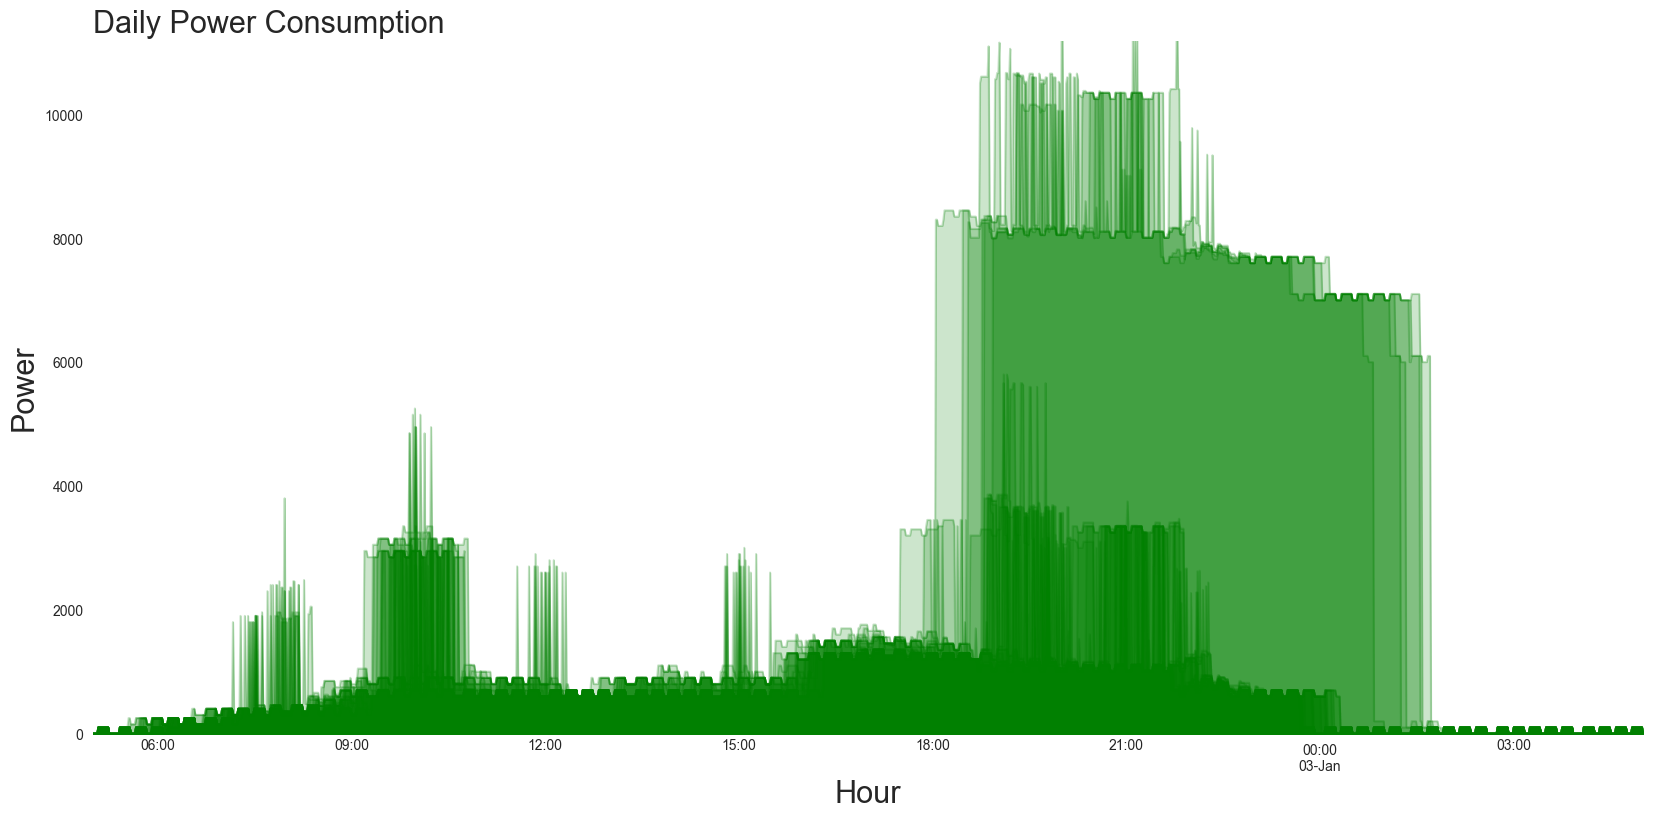

In [82]:
%%capture --no-display

# random.seed(9)

plt.style.use('seaborn')
sns.set_style("white")
plt.xlim((0, 8000))
sns.set_theme(style = "ticks")

directory = './consumption_input_file.xlsx'
sheet_name_list = list(pd.read_excel(directory, None).keys())
df_summary = pd.read_excel(directory, sheet_name = sheet_name_list[0], index_col='appliance')

start_time = datetime.datetime(2023, 1, 2, 5)
end_time = datetime.datetime(2023, 1, 3, 5)

for i in range (0,20):






    test_time_list = Time_list(start_time=start_time,
                               end_time=end_time
                              )

    df_master = pd.DataFrame(pd.Series(test_time_list.time_list), columns = ['time'])

    for sheet_name in sheet_name_list[1:]:

        df_temp = pd.read_excel(directory, sheet_name = sheet_name)[['time','power']].dropna()

        ##############
        # change input data points if recurring == 1
        ## objective is to change temp_points

        if df_summary.loc['{}'.format(sheet_name), '24_hour_recurring'] == 1:    
            concat_list = list(df_temp.itertuples(index=False, name=None))
            max_value = max([a for a, b in concat_list])

            ### loop for 24 hours
            while max_value <= 60*23:
                time_list = [a+max_value for a, b in concat_list]
                value_list = [b for a, b in concat_list]
                new_list = list(zip(time_list, value_list))
                concat_list = concat_list + new_list

                max_value = max([a for a, b in concat_list])  

                temp_points = concat_list
        else:  

            temp_points =  list(df_temp.itertuples(index=False, name=None))

        ##############
        # create Appliance

        temp_input = Appliance(name=sheet_name)
        temp_input.add_point(temp_points)

        ##############
        # create hour_list
        ## note: 24 hour itteration is already carried out above
        ### .iloc[:,9:] is to remove control columns and extract time columns

        hour_flat_list = list(df_summary.iloc[:,9:].loc['{}'.format(sheet_name)].dropna())
        hour_tutple_pair_list = []

        ##############

        ##############
        # Convert time list to pair of tuples
        for i in range(0, len(hour_flat_list), 2):
            hour_tutple_pair_list.append((hour_flat_list[i], hour_flat_list[i+1]))
        ##############

        ##############
        # Carry out operation if the time of the day is right
        day_of_week = day_of_the_week_dict[datetime.datetime(2023, 1, 2).weekday()]
        probability = df_summary.loc[:,day_of_week][sheet_name]

        random_number = random.random()
        if random_number <= probability:
            print(sheet_name, random_number)

            ##############

            for temp_time in hour_tutple_pair_list:
                base_time = datetime.datetime(2023, 1, 2,int(temp_time[0]), int(temp_time[1]))
                random_starting_time = df_summary.loc['{}'.format(sheet_name), 'range']
                starting_time = base_time + datetime.timedelta(minutes=int(np.random.normal(0, random_starting_time, 1)))
                test_time_list.add_item(temp_input, starting_time)

            df_temp_consolidate_1 = test_time_list.df_base.filter(regex='{}'.format(sheet_name))
            df_temp_consolidate_2 = pd.concat([pd.Series(test_time_list.time_list), df_temp_consolidate_1.T.sum()], axis=1)    
            df_temp_consolidate_2.columns = ['time', '{}'.format(sheet_name)]
            df_master = pd.merge(df_master, df_temp_consolidate_2, how='left', on = 'time')

    df_master_2 = df_master
    df_master_2.index = df_master_2.iloc[:,0]
    df_master_2 = df_master_2.iloc[:,1:]

    df_master_2.T.sum().plot.area(figsize = (20,9), 
                                  color = 'green', 
                                  alpha = 0.2)

# colors = sns.color_palette("RdBu", 7)

# df_master_2.plot.area(figsize = (20,9))
plt.title("Daily Power Consumption", fontsize = 22, loc = 'left')
plt.ylabel("Power", fontsize = 22)
plt.xlabel("Hour", fontsize = 22)
